<a href="https://colab.research.google.com/github/Daisuke-lab/segemnation-model/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install segmentation-models-pytorch

     |████████████████████████████████| 61kB 4.9MB/s 
     |████████████████████████████████| 163kB 17.5MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12421 sha256=9970a65611597091cffde5918e931ab48ff4020882c31e13739c4bca50fe02d8
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60964 sha256=4b075d66e3f59358682b9f63602d615aa77a2ca69f2edb6a50c09f5bf7b2a192
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-pinysz66
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-pinysz66
     |████████████████████████████████| 952kB 7.8MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=70462 sha256=5cf762b94c61d42e20bbcff2e96b7c34158fbc6c2a347668960820d8b4ea469e
  Stored in directory: /tmp/pip-ephem-wheel-cache-nylia70k/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
#import segmentation_models_pytorch as smp
import os
import glob
import random
import time

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid import ImageGrid

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

import albumentations as A
import copy
from albumentations.pytorch import ToTensor
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn



from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  if sys.path[0] == '':


In [ ]:
data = []
for dir in glob.glob('/content/drive/My Drive/Kaggle/kaggle_3m/*'):
  if os.path.isdir(dir):
    dir_name = dir.split('/')[-1]
    for file in os.listdir(dir):
      image_path = dir + '/' + file
      data.extend([dir_name, image_path])

In [ ]:
df = pd.DataFrame({"dirname" : data[::2],
                  "path" : data[1::2]})
df.head()

,dirname,path
0,TCGA_CS_4941_19960909,/content/drive/My Drive/Kaggle/kaggle_3m/TCGA_...
1,TCGA_CS_4941_19960909,/content/drive/My Drive/Kaggle/kaggle_3m/TCGA_...
2,TCGA_CS_4941_19960909,/content/drive/My Drive/Kaggle/kaggle_3m/TCGA_...
3,TCGA_CS_4941_19960909,/content/drive/My Drive/Kaggle/kaggle_3m/TCGA_...
4,TCGA_CS_4941_19960909,/content/drive/My Drive/Kaggle/kaggle_3m/TCGA_...


In [ ]:
#~df means not containing mask
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

In [ ]:
df_imgs.head(5)

,dirname,path
1,TCGA_CS_4941_19960909,/content/drive/My Drive/Kaggle/kaggle_3m/TCGA_...
3,TCGA_CS_4941_19960909,/content/drive/My Drive/Kaggle/kaggle_3m/TCGA_...
4,TCGA_CS_4941_19960909,/content/drive/My Drive/Kaggle/kaggle_3m/TCGA_...
5,TCGA_CS_4941_19960909,/content/drive/My Drive/Kaggle/kaggle_3m/TCGA_...
6,TCGA_CS_4941_19960909,/content/drive/My Drive/Kaggle/kaggle_3m/TCGA_...


In [ ]:
df_masks.head(5)

,dirname,path
0,TCGA_CS_4941_19960909,/content/drive/My Drive/Kaggle/kaggle_3m/TCGA_...
2,TCGA_CS_4941_19960909,/content/drive/My Drive/Kaggle/kaggle_3m/TCGA_...
9,TCGA_CS_4941_19960909,/content/drive/My Drive/Kaggle/kaggle_3m/TCGA_...
10,TCGA_CS_4941_19960909,/content/drive/My Drive/Kaggle/kaggle_3m/TCGA_...
11,TCGA_CS_4941_19960909,/content/drive/My Drive/Kaggle/kaggle_3m/TCGA_...


In [ ]:
len("/content/drive/My Drive/Kaggle/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_")

85

In [ ]:
BASE_LEN = 85 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
# 4 = .tif
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)
# 9 = _mask.tif

In [ ]:
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))
#they are sorted by /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ ""43""
# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/drive/My Drive/Kaggle/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_18.tif 
Path to the Mask: /content/drive/My Drive/Kaggle/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_18_mask.tif


In [ ]:
df.iloc[1, 1]

'/content/drive/My Drive/Kaggle/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif'

In [ ]:
# Final dataframe
#you can connect df like this because masks and images are the same number
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": imgs,
                   "mask_path": masks})


# Adding A/B column for diagnosis
#if there is something on masks picture, that is positive
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

#df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))

In [ ]:
#df.to_csv('/content/drive/My Drive/Kaggle/kaggle_3m/complete_csv')

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Kaggle/kaggle_3m/complete_csv')

In [ ]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

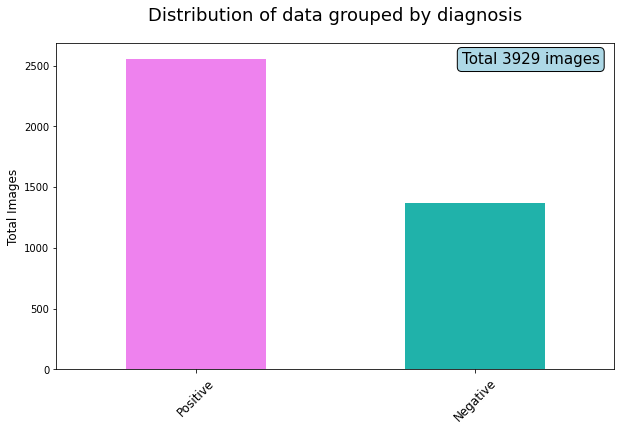

In [ ]:
ax = df.diagnosis.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["violet", "lightseagreen"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );

Text(0.5, 1.005, 'Distribution of data grouped by patient and diagnosis')

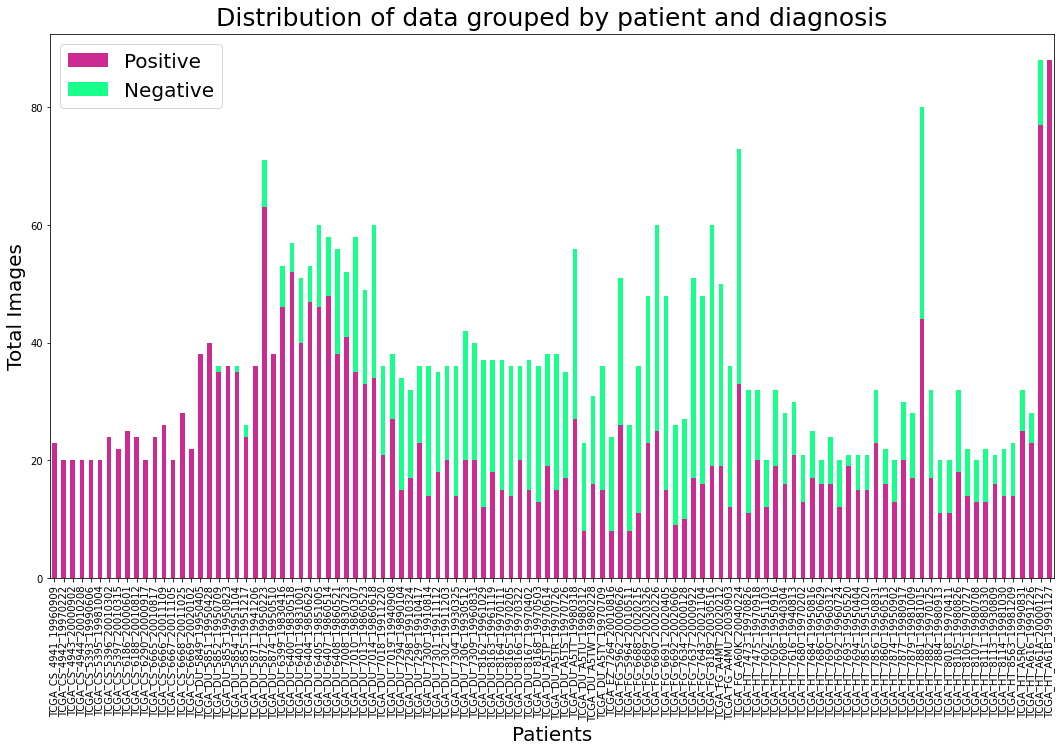

In [ ]:
#.size() get how many positive and negative on each person
#unstack() enable groupby to make new columns about each size of negative or positive
#df.groupby(['patient', 'diagnosis']) make a group of diagnosis on each patients

#patients_by_diagnosis = df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
patients_by_diagnosis = df.groupby(['patient', 'diagnosis']).size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

# Plot
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["mediumvioletred", "springgreen"], 
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)

Text(0.5, 0.95, 'Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset')

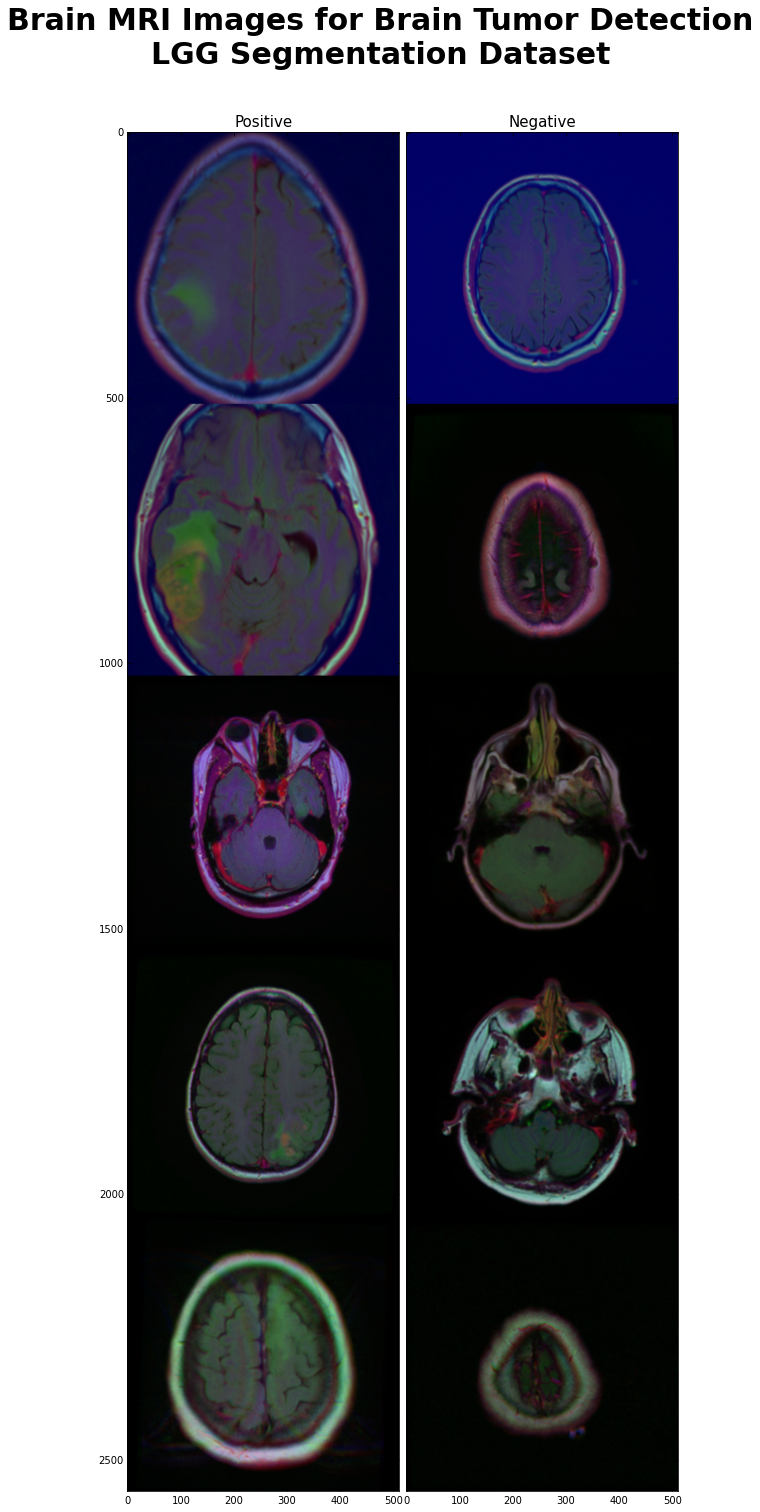

In [ ]:
sample_yes_df = df[df["diagnosis"] == 1].sample(5).image_path.values
sample_no_df = df[df["diagnosis"] == 0].sample(5).image_path.values
IMG_SIZE = 512
sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_yes_df, sample_no_df)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes, no])

#[::2] means take two steps at once
#[1::2] means take two steps and begin with index 1 
#vstacck is kind of extend in np
#it is needed becuase you picture 4 pictures as one picutre as following
sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

# Plot
#it enable pictures to be aligned
#grid is like making empty box to put pictures in
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")


# annotations
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

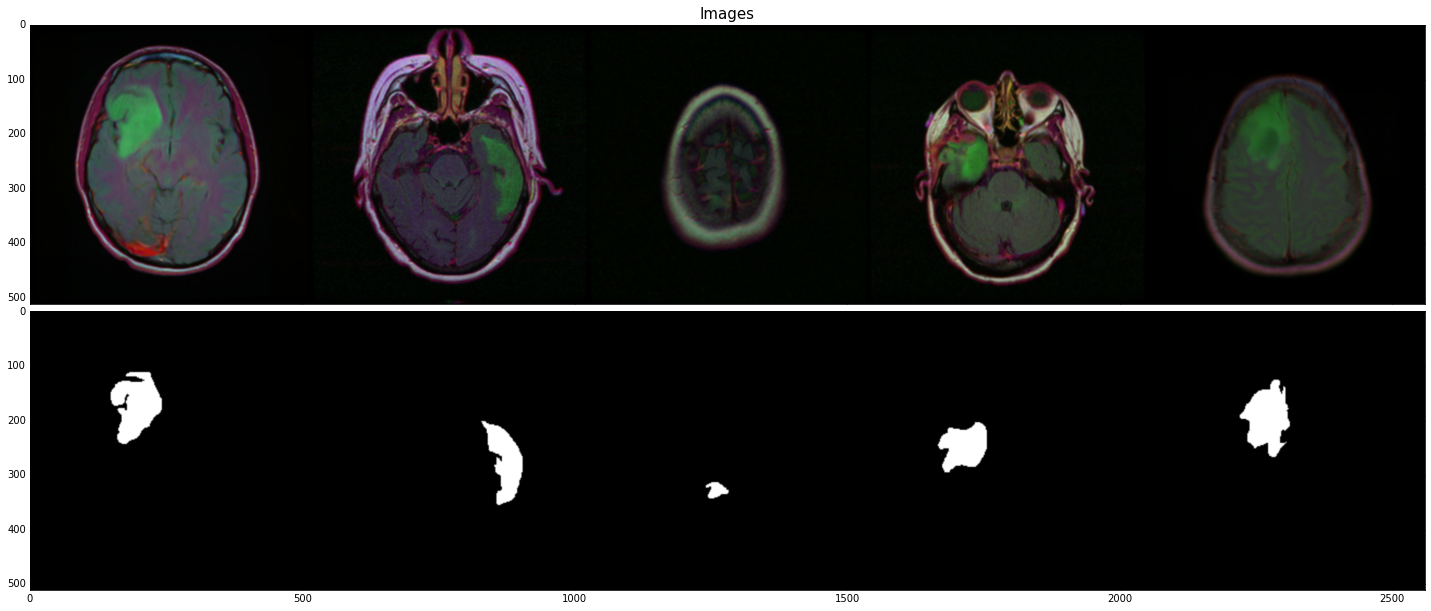

In [ ]:
sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    img = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])


sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")
plt.show()

In [ ]:

transformation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
    A.IAAEmboss(p=0.25),
    A.Blur(p=0.01, blur_limit = 3),
    
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
    ], p=0.8),
    
    A.Normalize(p=1.0),
])

In [ ]:
class CreateDataset(Dataset):
  def __init__(self, transforms, df, preprocessing=False):
    self.transforms = transforms
    self.df  = df
    self.preprocessing = preprocessing

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    image = cv2.imread(self.df.iloc[idx,1])
    mask = cv2.imread(self.df.iloc[idx, 2]) 
    mask = np.array(mask)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = mask[:, :, np.newaxis]
    image2 = image

    augmented = self.transforms(image=image, mask=mask)
    image = augmented['image']
    mask = augmented['mask']
    image3 = image


    if self.preprocessing:
      preprocessed = self.preprocessing(image=image, mask=mask)
      image = preprocessed['image']
      mask = preprocessed['mask']
      # image = torch.from_numpy(image.astype(np.float32))
      # mask = torch.from_numpy(mask.astype(np.float32))
      image = torch.tensor(image).float()
      mask = torch.tensor(mask).float()


      image = image.permute(2, 0, 1)
      mask = mask.permute(2, 0, 1)
    # mask = mask.squeeze(0)



    return image, mask, image2, image3

In [ ]:
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1)
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (393, 4) 
Test: (531, 4)


In [ ]:
def get_preprocessing(preprocessing_fn):

    _transform = [
        A.Lambda(image=preprocessing_fn),]
    return A.Compose(_transform)

In [ ]:
#DATA
preprocessing_fn = smp.encoders.get_preprocessing_fn('resnet50', pretrained='imagenet')
# train
train_dataset = CreateDataset(df=train_df, transforms=transformation, preprocessing=get_preprocessing(preprocessing_fn))
train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True)

# val
val_dataset = CreateDataset(df=val_df, transforms=transformation, preprocessing=get_preprocessing(preprocessing_fn))
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=4, shuffle=True)

#test
test_dataset = CreateDataset(df=test_df, transforms=transformation, preprocessing=get_preprocessing(preprocessing_fn))
test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=4, shuffle=True)

[-2.117904   -2.1007793  -2.0836544  -2.0665298  -2.0494049  -2.0357144
 -2.0322802  -2.0182073  -2.0151553  -2.0007002  -1.9980307  -1.9831933
 -1.9809059  -1.9656863  -1.9637811  -1.9481792  -1.9466563  -1.9306723
 -1.9295317  -1.9131652  -1.9124069  -1.8956583  -1.8952821  -1.8781574
 -1.8781513  -1.8610326  -1.8606442  -1.8439078  -1.8431373  -1.8267831
 -1.8256303  -1.8096584  -1.8081232  -1.7925336  -1.7906163  -1.7754089
 -1.7731092  -1.7695861  -1.7582841  -1.7556022  -1.7521569  -1.7411593
 -1.7380953  -1.7347276  -1.7240345  -1.7205882  -1.7172985  -1.7069099
 -1.7030813  -1.6998693  -1.6897851  -1.6855742  -1.68244    -1.6726604
 -1.6680672  -1.6650109  -1.6555356  -1.6505603  -1.6475817  -1.6384108
 -1.6330532  -1.6301525  -1.621286   -1.6155462  -1.6127234  -1.6041613
 -1.5980393  -1.5952941  -1.5870366  -1.5805322  -1.5778649  -1.5699118
 -1.5630252  -1.5604358  -1.5527871  -1.5455182  -1.5430065  -1.5356623
 -1.5280112  -1.5255773  -1.5185375  -1.5105042  -1.5081482  -1.

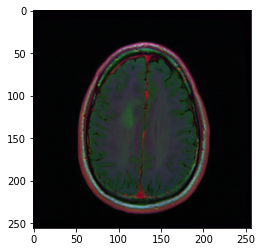

In [ ]:
image, mask, image2, image3 = train_dataset[9]
print(np.unique(np.array(image)))
image = image.permute(1,2,0)
image = np.array(image)
print(image.shape)
plt.imshow(image2)

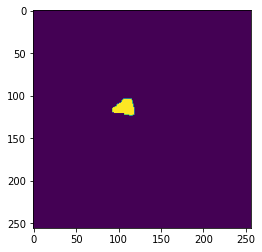

In [ ]:
mask = mask.permute(1,2,0)
mask = np.array(mask)
mask = np.squeeze(mask)
plt.imshow(mask)

In [ ]:
x,y = next(iter(train_dataloader))
y.shape

torch.Size([32, 1, 256, 256])

In [ ]:
output = model(x.to(device))

/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


tensor([[[[ 2.5579e-04, -4.1875e+00, -7.5526e+00,  ..., -6.4309e+00,
           -3.5892e+00, -4.0379e+00],
          [-4.4118e+00, -7.4030e+00, -6.0570e+00,  ..., -9.7212e+00,
           -5.5335e+00, -3.5144e+00],
          [-7.0291e+00, -6.1318e+00, -8.7491e+00,  ..., -1.0619e+01,
           -9.7212e+00, -4.8605e+00],
          ...,
          [-8.8986e+00, -6.2813e+00, -5.9074e+00,  ..., -6.5804e+00,
           -6.1318e+00, -6.2813e+00],
          [-9.4221e+00, -8.8239e+00, -6.2813e+00,  ..., -5.9822e+00,
           -6.2813e+00, -6.5057e+00],
          [-7.1039e+00, -9.1978e+00, -8.5247e+00,  ..., -6.3561e+00,
           -6.5057e+00, -8.0760e+00]],

         [[-7.7630e+00, -9.2480e+00, -8.7009e+00,  ..., -9.2480e+00,
           -9.2480e+00, -8.5446e+00],
          [-9.6388e+00, -9.5606e+00, -4.0115e+00,  ..., -8.9353e+00,
           -8.7790e+00, -9.3261e+00],
          [-9.9514e+00, -3.3081e+00, -9.8732e+00,  ..., -1.0655e+01,
           -1.0108e+01, -8.6227e+00],
          ...,
     

In [ ]:
def get_IoU(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

In [ ]:
#LOSS_FUNC

#this function is a part of bce_dice_loss
def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

In [ ]:
#SCHEDULER

#warmup_factor = 1.0 / 100 warmup_iters = min(100, len(train_loader) - 1)
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x): #x is step(iteration)
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha
    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'

ACTIVATION = None
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation='softmax',
)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
# model.segmentation_head[0]=nn.Sequential(
# nn.Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
# nn.Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1)))

In [ ]:
#OPTIMIZER

unet_optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3)

In [ ]:
def train_model(model, train_loader, val_loader,  loss_func, optimizer, lr_scheduler, num_epochs):
    model = model.to(device)
    since = time.time()

    train_loss_list = []
    val_loss_list = []
    loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 30)

        loss_per_epoch = []
        train_IoU = []



        for phase in ['train', 'val']:


          #TRAIN
          if phase == 'train':
            model.train()

            with torch.set_grad_enabled(phase == 'train'):
  
              for step, (data, target) in enumerate(train_loader):
                  
                  data = data.to(device)
                  target = target.to(device)

        
                  output = model(data)
                  

                  loss = loss_func(output, target)

                  optimizer.zero_grad()
                  loss.backward()
                  optimizer.step()

                  out_cut = np.copy(output.data.cpu().numpy())
                  target_cut = np.copy(target.data.cpu().numpy())

                  out_cut[out_cut < 0.5] = 0.0
                  out_cut[out_cut >= 0.5] = 1.0

                  IoU = get_IoU(out_cut, target_cut)

                  loss_per_epoch.append(loss.item())
                  train_IoU.append(IoU)

                  if lr_scheduler:
                    lr_scheduler.step()

         #EVALUATION
          else:
            model.eval()
            val_loss = 0

            with torch.no_grad():


              for step, (data, target) in enumerate(val_loader):
                data = data.to(device)
                target = target.to(device)

                output = model(data)

                out_cut[out_cut < 0.3] = 0.0
                out_cut[out_cut >= 0.3] = 1.0

                IoU = get_IoU(out_cut, target_cut)
                
                val_loss += IoU

            #step = last step = the number of step
            val_loss_mean = val_loss / step



        loss_history.append(np.array(loss_per_epoch).mean())
        train_loss_list.append(np.array(train_IoU).mean())
        val_loss_list.append(val_loss_mean)
        print("Mean loss on train:", np.array(loss_per_epoch).mean(), 
              "\nMean DICE on train:", np.array(train_IoU).mean(), 
              "\nMean DICE on validation:", val_loss_mean)


    return loss_history, train_loss_list, val_loss_list

In [ ]:
loss_history, train_loss, val_loss_list = train_model(model, train_dataloader, val_dataloader, bce_dice_loss, unet_optimizer, False, 10 )

Epoch 0/9
------------------------------


/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Mean loss on train: -202.2147518117377 
Mean DICE on train: 1.4602126826311033 
Mean DICE on validation: 1.4169416186585495
Epoch 1/9
------------------------------
Mean loss on train: -201.74415299740244 
Mean DICE on train: 1.4595262542358036 
Mean DICE on validation: 1.7313421333225645
Epoch 2/9
------------------------------
Mean loss on train: -201.93562702422446 
Mean DICE on train: 1.4655079702031257 
Mean DICE on validation: 1.6968141938658101
Epoch 3/9
------------------------------
Mean loss on train: -204.56818277531482 
Mean DICE on train: 1.4825258315232048 
Mean DICE on validation: 1.7507289536753439
Epoch 4/9
------------------------------
Mean loss on train: -206.75045102707884 
Mean DICE on train: 1.4719854139368496 
Mean DICE on validation: 1.524942771756044
Epoch 5/9
------------------------------
Mean loss on train: -202.8255325118278 
Mean DICE on train: 1.447717290865617 
Mean DICE on validation: 1.0794594069402228
Epoch 6/9
------------------------------
Mean los

/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


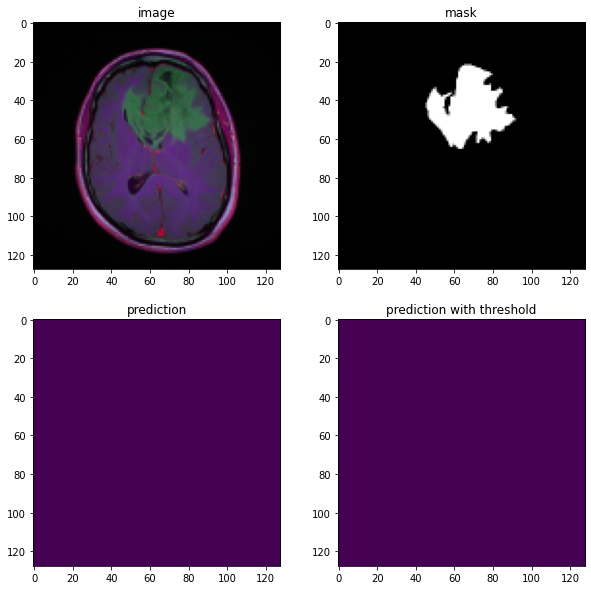

In [ ]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

mask = cv2.resize(cv2.imread(test_sample[2]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.#1.0
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()